In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


In [5]:
from context import record_main as recmain
from context import wavelet
import treatrec as treat
from treatrec import ekg_to_hr

In [6]:
def load(tfile = 'M2020_2_4-9_49_5.csv',
         wfile = 'M2020_2_4-9_49_5Wave.csv',
         dir_loc = '~/enva/clinique/recordings/anesthRecords/onPanelPcRecorded'):
    
    #files:
    if os.path.isfile(tfile):
        trend_filename = tfile
    else:
        trend_filename = os.path.join(dir_loc, tfile)
        
    if os.path.isfile(wfile):
        wave_filename = wfile
    else:
        wave_filename = os.path.join(dir_loc, wfile)  
        
    #trends
    monitorTrend = recmain.MonitorTrend(trend_filename)
    params = recmain.build_param_dico(file=tfile, source='monitorTrend')
    #waves
    monitorWave = recmain.MonitorWave(wave_filename)
    params = recmain.build_param_dico(file=wfile, source='monitorWave')
    params['fs'] = float(monitorWave.header['Data Rate (ms)'])*60/1000
    params['kind'] = 'as3'
    monitorWave.param = params
    #remove unnecessary waves
    for item in ['wflow', 'wawp', 'wvp']:
        del monitorWave.data[item]
    return monitorTrend, monitorWave


In [7]:
monitorTrend, monitorWave = load(tfile='../data/recordingTest/trend.csv',
                                 wfile='../data/recordingTest/wave.csv')

loading  wave.csv


In [8]:
params = monitorWave.param
print(params)

{'item': 1, 'xmin': None, 'xmax': None, 'ymin': 0, 'ymax': None, 'path': '/home/yzerlaut/work/anesthPlot/data', 'unit': 'min', 'save': False, 'memo': False, 'file': '../data/recordingTest/wave.csv', 'source': 'monitorWave', 'fs': 300.0, 'kind': 'as3'}


source = Python port of BaselineWanderRemovalMedian.m from ECG-kit
Alex Page, alex.page@rochester.edu
https://bitbucket.org/atpage/baselinewanderremoval/src/master/


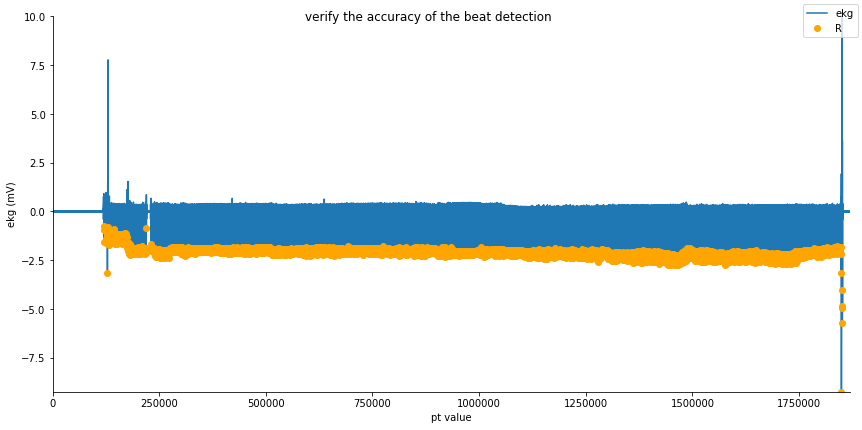

In [10]:
ekg_df = pd.DataFrame(monitorWave.data.wekg)*(-1)

#low pass filtering
ekg_df['wekg_lowpass'] = recmain.wf.fix_baseline_wander(ekg_df.wekg,
                                                monitorWave.param['fs'])
# beats locations (beat based dataFrame)
beat_df = treat.ekg_to_hr.detect_beats(ekg_df.wekg_lowpass, params)
#plot
figure = treat.ekg_to_hr.plot_beats(ekg_df.wekg_lowpass, beat_df)

#fs=300
beat_df= treat.ekg_to_hr.compute_rr(beat_df, monitorWave.param)
hr_df = treat.ekg_to_hr.interpolate_rr(beat_df)


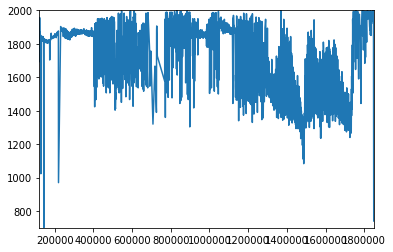

In [11]:
plt.plot(beat_df.pLoc, beat_df.rr)

In [36]:
dt = 1./300.
t, data = np.array(beat_df.pLoc)*dt, np.array(beat_df.rr)-np.mean(beat_df.rr)
freqs = np.logspace(-3, 1, 20)
coefs = wavelet.my_cwt(data, freqs, dt, wavelet='morlet')

In [ ]:
def time_freq_plot(t, freqs, data, coefs):
    """
    a plot to illustrate the output of the wavelet analysis
    """
    dt = t[1]-t[0]

    fig = plt.figure(figsize=(8,5))
    plt.subplots_adjust(wspace=.8, hspace=.5, bottom=.2)
    # signal plot
    plt.subplot2grid((3, 8), (0,0), colspan=6)
    plt.plot(1e3*t, data, 'k-', lw=2)
    plt.ylabel('signal')
    plt.xlim([1e3*t[0], 1e3*t[-1]])
    # time frequency power plot
    ax1 = plt.subplot2grid((3, 8), (1,0), rowspan=2, colspan=6)
    c = plt.contourf(1e3*t, freqs, coefs, cmap='PRGn', aspect='auto')
    plt.xlabel('time (ms)')
    plt.ylabel('frequency (Hz)')
    plt.yscale('log')
    # inset with legend
    acb = plt.axes([.8, .7, .02, .2])
    plt.colorbar(c, cax=acb, label='coeffs (a.u.)', ticks=[-1, 0, 1])
    # mean power plot over intervals
    plt.subplot2grid((3, 8), (1, 6), rowspan=2)
    plt.barh(freqs, np.power(coefs,2).mean(axis=1)*dt)
    plt.xticks([]);
    plt.xlabel(' mean \n power \n (a.u.)')
    # max of power over intervals
    plt.subplot2grid((3, 8), (1, 7), rowspan=2)
    plt.barh(freqs, np.power(coefs,2).max(axis=1)*dt)
    plt.xticks([]);
    plt.xlabel(' max. \n power \n (a.u.)');
    return fig

/home/yzerlaut/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'aspect'
  app.launch_new_instance()


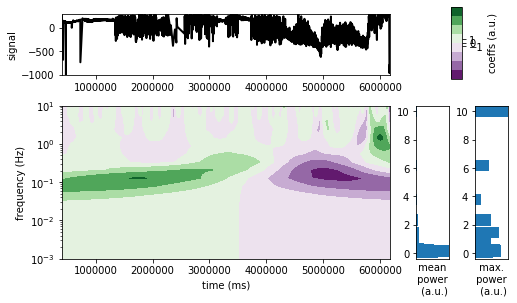

In [47]:
time_freq_plot(t, freqs, data, coefs);